In [1]:
!nvidia-smi

Tue May 16 15:31:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:D8:00.0 Off |                    0 |
| N/A   36C    P0    53W / 250W |      0MiB / 46080MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import timm
import datetime
from torch.nn import functional as F
from sklearn.neighbors import NearestNeighbors
import numpy as np
# from model import Head, MultiCrop,DinoLoss
# from Augmentation import DataAugmentation
# from PIL import ImagePath
# from torchvision.datasets import ImageFolder
# import pathlib
# from torch.utils.data import DataLoader, SubsetRandomSampler
# model and dim values


mobile_models = {
    'mobilevit_s':640,
    'mobilevit_xs':640,
    'mobilevit_xxs':640,
    'mobilenetv2_035':640,
    'mobilenetv2_075':640,
    'mobilenetv2_100':640,
    'resnet5m':512,   
}

class mobilenet(nn.Module):
    def __init__(self,
                 model:str = 'mobilevit_s',
                 pretrained=False):
        super(mobilenet,self).__init__()
        self.backbone = timm.create_model(model,pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.num_features = self.backbone.num_features

    def forward(self,x):
        x = self.backbone(x)
        return x

class MultiCrop(nn.Module):
    """
    backbone: timm.models.vision_transformer.VisionTransformer
    new_head: head

    """

    def __init__(self,
                 backbone,
                 new_head,
                 mobile_head=False
                 ) -> None:
        super().__init__()
        self.mobile_head =mobile_head 

        #setting up the model
        self.backbone = backbone
        backbone.head= nn.Identity()
        self.new_head = new_head


    def forward(self,x):
        """
        x is List of torch.Tensor of shape (n_samples, 3,size,size)
        
        """
        n_crops = len(x)
        #print("len of batch ",len(x))
        concatenated_tensor = torch.cat(x,dim=0) 
        # (n_samples*n_crops, 3, size, size)
        # example batch size of 64 we have [640,3, 224,224] for size crops of 10: 2G,8L
        
        #print("shape of concat tensor",concatenated_tensor.shape)
        cls_embedding = self.backbone(concatenated_tensor) # (n_samples * n_crops, in_dim)
        #print(cls_embedding.shape, "cls embedding")
        logits =self.new_head(cls_embedding) # n_samples * n_crops, out_dim

        chunks = logits.chunk(n_crops) # n_crops * (n_samples,outdim)
        
        return chunks


class Head(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 hidden_dim = 512,
                 bottleneck_dim = 256,
                 n_layers =3,
                 norm_last_layer=False,
                 init_weights=["normal",""] # yet to define
                 ) -> None:
        super().__init__()
        
        # create a Multilayer perceptron based on the layer number from in dim to out dim
       
        if n_layers ==1:
            self.mlp =nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            layers.append(nn.SELU())
            for _ in range(n_layers-2):
                layers.append(nn.Linear(hidden_dim,hidden_dim))
                layers.append(nn.SELU())
            layers.append(nn.Linear(hidden_dim,bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        
        
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(
            nn.Linear(bottleneck_dim,out_dim,bias=False)
        )
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad=False
        
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias,0)

    def forward(self,x):
        x= self.mlp(x)
        x= F.normalize(x,dim=-1,p=2)
        x=self.last_layer(x)
        return x
    


import torch.nn as nn
import timm
from torch.nn import functional as F



class ResBlock(nn.Module):
    def __init__(self,
                inchannels,
                outchannels,
                kernel_size=3,
                stride=1,
                skip=True):
        super().__init__()
        # Determines whether to add the identity mapping skip connection
        self.skip = skip
        
        # First block of the residual connection
        self.block = nn.Sequential(
            nn.Conv2d(inchannels,
                    outchannels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=1,
                    bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannels,
                    outchannels,
                    kernel_size=kernel_size,
                    padding=1,
                    bias=False),
            nn.BatchNorm2d(outchannels),
        )
        
        # If the stride is 2 or input channels and output channels do not match,
        # then add a convolutional layer and a batch normalization layer to the identity mapping
        if stride == 2 or inchannels != outchannels:
            self.skip = False
            self.skip_conv = nn.Conv2d(inchannels, outchannels, kernel_size=1, stride=stride, bias=False)
            self.skip_bn = nn.BatchNorm2d(outchannels)

    def forward(self, x):
        out = self.block(x)
        
        # If the skip connection is active, add the input to the output
        # If the skip connection is not active, add the skip connection to the output
        if not self.skip:
            out += self.skip_bn(self.skip_conv(x))
        else:
            out += x
        
        out = F.relu(out.clone())
        return out
def save_checkpoint(checkpoint_dir, epoch, model, knn_acc,args,time, linear_acc=0, checkpoint_filename="student_model"):
    now = datetime.datetime.now()
    iteration_dir = now.strftime("%Y-%m-%d_%H-%M-%S")+'_epoch_'+str(epoch)
    print(iteration_dir)
    os.makedirs(os.path.join(checkpoint_dir, iteration_dir))

    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        
        'knn_accuracy': knn_acc,
        'linear_acc':linear_acc
    }

    #print(checkpoint_data)
    checkpoint_path = os.path.join(checkpoint_dir, iteration_dir, checkpoint_filename + "_epoch{}.pth".format(epoch))
    torch.save(checkpoint_data, checkpoint_path)
    print(checkpoint_path)
    # Save the args and accuracy to a separate file
    args_filename = os.path.join(checkpoint_dir, iteration_dir, "args.txt")
    with open(args_filename, "w") as f:
        
            f.write("{}\n".format(str(args)))
    accuracy_filename = os.path.join(checkpoint_dir, iteration_dir, "accuracy.txt")
    print(accuracy_filename)
    with open(accuracy_filename, "a") as f:
        f.write("Epoch {}: KNN accuracy = {}\n".format(epoch, knn_acc))
        f.write("Epoch {}: Linear accuracy = {}\n".format(epoch, linear_acc))
        f.write("Time to comeplete the Epoch = {}\n".format(time))
        
        

class ResNet5M(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initial convolutional layer and batch normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # Residual blocks
        self.resblock3 = ResBlock(64, 64, stride=1)
        self.resblock6 = ResBlock(64, 64, stride=1)
        self.resblock7 = ResBlock(64, 64, stride=1)
        self.resblock8 = ResBlock(64, 128, stride=2)
        self.resblock9 = ResBlock(128, 128, stride=1)
        self.resblock10 = ResBlock(128, 128, stride=1)
        self.resblock11 = ResBlock(128, 128, stride=1)
        self.resblock12 = ResBlock(128, 128, stride=1)
        self.resblock13 = ResBlock(128, 128, stride=1)
        self.resblock14 = ResBlock(128, 512, stride=2)
        
        # Global average pooling and fully-connected layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat = nn.Flatten()
        # self.fc = nn.Linear(in_features=512, out_features=2048, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x.clone())
        x = self.maxpool(x)
        x = self.resblock3(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.avgpool(x)
        x = self.flat(x)
        # x = self.fc(x) 
        return x



/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to('cuda')


1281167
Files already downloaded and verified


Using cache found in /home/sp7238/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


1281167
Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/sp7238/.cache/torch/hub/facebookresearch_dinov2_main


Accuracy on validation set after epoch 1: 40.77%
Accuracy on validation set after epoch 2: 46.78%
Accuracy on validation set after epoch 3: 49.82%
Accuracy on validation set after epoch 4: 51.81%
Accuracy on validation set after epoch 5: 53.17%
Accuracy on validation set after epoch 6: 54.37%
Accuracy on validation set after epoch 7: 55.21%
Accuracy on validation set after epoch 8: 55.91%
Accuracy on validation set after epoch 9: 56.58%
Accuracy on validation set after epoch 10: 57.16%
Accuracy on validation set after epoch 11: 57.64%
Accuracy on validation set after epoch 12: 58.07%
Accuracy on validation set after epoch 13: 58.48%
Accuracy on validation set after epoch 14: 58.83%
Accuracy on validation set after epoch 15: 59.21%
Accuracy on validation set after epoch 16: 59.48%
Accuracy on validation set after epoch 17: 59.79%
Accuracy on validation set after epoch 18: 60.05%
Accuracy on validation set after epoch 19: 60.30%
Accuracy on validation set after epoch 20: 60.51%
Accuracy 

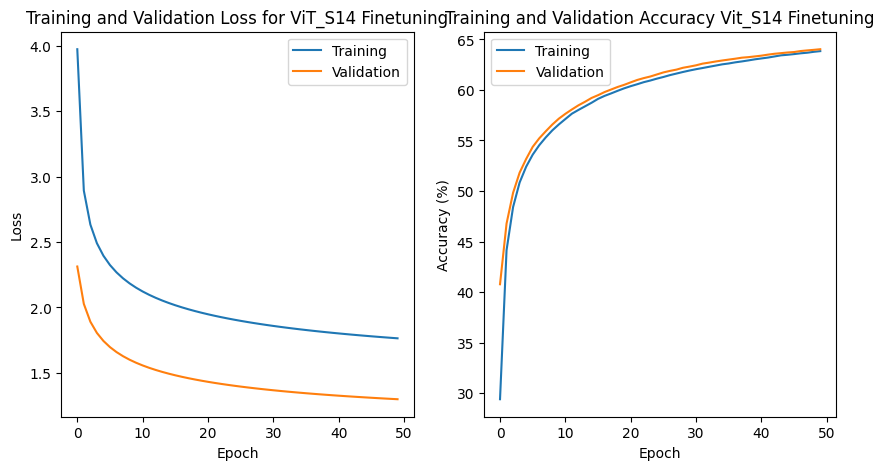

In [8]:
#training script to get the trained fully connected layer

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# Lists to store the training and validation loss and accuracy

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import os
import torch
import sys
import pathlib
import torch.nn as nn
import torch.distributed as dist
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import __main__

transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Resize((56,56)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])




IMAGENET1K_TRAIN ="/vast/work/public/ml-datasets/imagenet/train"
IMAGENET1K_TEST = "/scratch/sp7238/DL/data/val/val_2"

img_train_small = "/scratch/sp7238/DL/LowDINO/custom/data/imagenette2-320/train"
img_val_small ="/scratch/sp7238/DL/LowDINO/custom/data/imagenette2-320/val"


path_dataset_train = pathlib.Path(IMAGENET1K_TRAIN)
path_dataset_val = pathlib.Path(IMAGENET1K_TEST)

img_train_small = pathlib.Path(img_train_small)
img_val_small = pathlib.Path(img_val_small)




transform_plain = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((224, 224)),
        ]
    )

dataset_train_aug = ImageFolder(path_dataset_train, transform=transform_plain)
#dataset_train_plain = ImageFolder(path_dataset_train, transform=transform_plain)
dataset_val_plain = ImageFolder(path_dataset_val, transform=transform_plain)



tr_split_len =150000
print(len(dataset_train_aug))
    
dataset_train_aug = torch.utils.data.random_split(dataset_train_aug, [tr_split_len,\
                                                              len(dataset_train_aug)-tr_split_len])[0]



train_dataloader = DataLoader(
        dataset_train_aug,
        batch_size=2048,
        shuffle=True,
        drop_last=True,
        num_workers=int(3),
        pin_memory=True
    )
test_dataloader = DataLoader(
        dataset=dataset_val_plain,
        batch_size=1024,
        shuffle=True,
        drop_last=True,
        num_workers=int(3),
        pin_memory=True)
    


cifar_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

cifar_dataset_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
batch_size = 512
dataloader = data.DataLoader(cifar_dataset, batch_size=batch_size, shuffle=False)

dataloader_test = data.DataLoader(cifar_dataset, batch_size=64, shuffle=False)





# setattr(__main__, "resnet_model", resnet_model)
# resnet_model.load_state_dict(torch.load('res_512.pt'))
num_classes = 100


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(resnet_model.parameters(), lr=0.05, momentum=0.9)
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []


# Load the DINO ResNet50 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to('cuda')



# Freeze the DINO model's parameters
for param in dino_model.parameters():
    param.requires_grad = False

# Replace the final layer of the DINO model with a new classification layer
num_classes = 100
# dino_model.flatten= nn.Flatten()
fc = nn.Linear(384, num_classes).to('cuda')

# Define the loss function (cross-entropy) and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc.parameters(), lr=0.1)

# Define the dataset and data loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
prev_accuracy=0
# Train the classification model
for epoch in range(50):
    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the DINO model
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        features = dino_model(inputs)
        
        # Forward pass through the classification layer
        outputs = fc(features)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Compute the loss and update the weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    # Append the training loss to history
    train_loss_history.append(running_loss / len(train_dataloader))
    
    # Compute the accuracy on the training set
    train_accuracy = 100 * train_correct / total
    train_acc_history.append(train_accuracy)
    
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader_test:
            images = images.to('cuda')
            labels = labels.to('cuda')
            features = dino_model(images)
            outputs = fc(features)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * labels.size(0)
    
    # Compute the validation loss and accuracy
    val_loss /= val_total
    val_loss_history.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_acc_history.append(val_accuracy)
    
    # Save the best model based on validation accuracy
    if val_accuracy > prev_accuracy:
        torch.save(fc.state_dict(), "vits_fc_trained_CIFAR100.pt")
        prev_accuracy = val_accuracy
        
    print('Accuracy on validation set after epoch %d: %.2f%%' % (epoch + 1, val_accuracy))
    

    
    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ViT_S14 Finetuning')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training')
plt.plot(val_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Vit_S14 Finetuning')
plt.legend()
plt.show()


In [29]:

mobile_model_convergence = nn.Sequential(
    nn.AdaptiveAvgPool1d(384),
    nn.Flatten()
).to('cuda') 


for p in dino_model.parameters():
   p.requires_grad=False


mobile_vit = mobilenet(pretrained=True).to('cuda')
mobile_fc = nn.Linear(640,100).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_vit.parameters(), lr=0.0005)
optimizer_fc = optim.SGD(mobile_fc.parameters(), lr =0.001)



In [30]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from sklearn.metrics import accuracy_score

def compute_embeddings(resnet_model, embedding_size=640,k=5):
    transform = transforms.Compose([

        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

    cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    batch_size = 32
    dataloader = data.DataLoader(cifar_dataset, batch_size=batch_size, shuffle=False)
    num_samples = len(cifar_dataset)
    
    embeddings = np.zeros((num_samples, embedding_size))


    resnet_model.eval()
    resnet_model=resnet_model.to('cuda')
    with torch.no_grad():
        image_idx = 0
        for images, _ in dataloader:
            batch_size = images.size(0)
            images = images.to('cuda')  

            outputs = resnet_model(images)
            # outputs = model(images)

            embeddings[image_idx:image_idx+batch_size] = outputs.squeeze().cpu().numpy()

            image_idx += batch_size
    
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(embeddings)

    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


    output_tensor = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to('cuda') 
            output = resnet_model(images)
            # output = model(images)
            output_tensor.append(output.squeeze().cpu().numpy())

    output_tensor = np.stack(output_tensor)
    _, indices = knn.kneighbors(output_tensor)
    label_array = cifar_dataset.targets
    true_test_labels=test_dataset.targets
    test_labels = []
    for i in range(len(indices)):
        train_indices = indices[i]
        first_train_label = label_array[train_indices[0]]
        test_labels.append(first_train_label)

    return accuracy_score(true_test_labels,test_labels)
    

In [31]:
temperature = 3.0  # Temperature value for distillation

args ={
    "batch_size": 100,
    "model":"MobileVIT",
    "distillation_model":"DINO ViT_S",
    "lr":0.05,
    "loss":"KL_divergence",
    "temperature":3.0  
}
# Assuming you have a dataloader for your dataset


for epoch in range(100):
    iter_count=0
    print("present running epoch=>", epoch)
    for images, labels in dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        # Forward pass on DINO v1 ResNet50 backbone
        with torch.no_grad():
            dino_features = dino_model(images)/temperature
            #Dino_convergent_features = DINO_Convergent(dino_features)
            dino_fc = fc(dino_features)
           
        
        # Forward pass on ResNet model
        outs = mobile_vit(images) 
        
        convergent_values_mobile = mobile_model_convergence(outs)/ temperature
        outputs_res = mobile_fc(outs)
        
        
        # print(dino_features.shape)
        print(convergent_values_mobile.shape)
        # break

        # Calculate the loss with distillation
        distillation_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(convergent_values_mobile, dim=1),
            torch.nn.functional.softmax(dino_features, dim=1),
            reduction='batchmean'
        )

        # Calculate the classification loss
        classification_loss = criterion(outputs_res,labels)
        

        
        
        # Calculate the total loss
        total_loss = distillation_loss+classification_loss
                                        
        print("total loss => ", total_loss.item(),"iteration count =>", iter_count)
        iter_count+=1
        
        # Backward and optimize
        optimizer.zero_grad()
        optimizer_fc.zero_grad()
        total_loss.backward()
        optimizer.step()
        optimizer_fc.step()
        
    if epoch%2==0:
        
        #checkpoint_dir, epoch, model, knn_acc,args,time, linear_acc=0, checkpoint_filename="student_model"
        save_checkpoint("Distillation_directory_ViTS14_MobileVIT_class_ssl_2",epoch,mobile_vit,compute_embeddings(mobile_vit),args,time=0)


present running epoch=> 0
torch.Size([512, 384])
total loss =>  4.94001579284668 iteration count => 0
torch.Size([512, 384])
total loss =>  4.92751932144165 iteration count => 1
torch.Size([512, 384])
total loss =>  4.916359901428223 iteration count => 2
torch.Size([512, 384])
total loss =>  4.90610933303833 iteration count => 3
torch.Size([512, 384])
total loss =>  4.8784332275390625 iteration count => 4
torch.Size([512, 384])
total loss =>  4.866242408752441 iteration count => 5
torch.Size([512, 384])
total loss =>  4.853842735290527 iteration count => 6
torch.Size([512, 384])
total loss =>  4.834565162658691 iteration count => 7
torch.Size([512, 384])
total loss =>  4.825439929962158 iteration count => 8
torch.Size([512, 384])
total loss =>  4.7979936599731445 iteration count => 9
torch.Size([512, 384])
total loss =>  4.782919406890869 iteration count => 10
torch.Size([512, 384])
total loss =>  4.765957832336426 iteration count => 11
torch.Size([512, 384])
total loss =>  4.733589172